In [33]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, RMSprop

from lvi.components import DeterministicTensor, StochasticTensor, StochasticNetwork, FF_BNN
from lvi.optimizers import SGLD, pSGLD

(torch.Size([500, 1]), torch.Size([500, 1]))

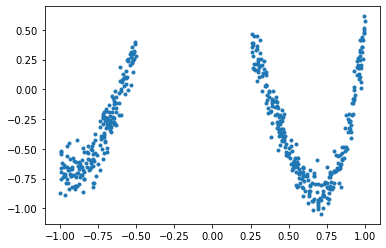

In [17]:
# Create a toy 1-D regression problem
np.random.seed(0)
N = 500
x1 = np.random.random(200) * 0.5 - 1.0    # \in [-1, -0.5]
x2 = np.random.random(300) * 0.75 + 0.25  # \in [0.25, 1]
x = np.concatenate([x1, x2])
x_range = np.linspace(-2, 2, 1200)
mu = 4.4 * x**4 + 1.9 * x**3 + -5.4 * x**2 - 1.3 * x**1 + 1.0 * x**0
std = 0.1
y = mu + np.random.randn(500) * std
plt.plot(x,y, '.')

X, Y = torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor(y).unsqueeze(-1)
X_range = torch.FloatTensor(x_range).unsqueeze(-1)
X.shape, Y.shape  # size: (data_batch_size, input/output_size)

In [34]:
model_arch_args = dict(
    num_inputs=1,
    num_outputs=1,
    num_layers=2,
    hidden_sizes=[50,50],
    activation_func=nn.Tanh, #nn.ReLU,
    chain_length=5000,
    stochastic_biases=False,
    output_distribution="normal",
    output_dist_const_params=dict(scale=std),
)

sgld_model_args = dict(
    group_by_layers=False,
    use_random_groups=False,
    use_permuted_groups=False,
    max_groups=None,
    dropout_prob=None,
    **model_arch_args,
)

In [49]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sgld_model = FF_BNN(**sgld_model_args)
sgld_model.initialize_optimizer(
    update_determ=True, 
    update_stoch=True, 
    lr=1e-5, #1e-5, 
    sgd=True, 
    sgld=False, 
    psgld=False,
)

In [50]:
import pickle
pickle.dump(sgld_model_args, open("./test_sgld_model_params.pickle", "wb"))

In [51]:
num_epochs = 50000
for i in range(num_epochs):
    loss = sgld_model.training_step(
        batch=(X,Y),
        N=N,
        deterministic_weights=True,
        vi_batch_size=None,
    )

    if (i+1) % 10**math.floor(math.log10(i+1)) == 0:  # True when i+1 \in {1, 2, ..., 10, 20, ..., 100, 200, ..., 1000, 2000, ...}
        print("Iter {} / {}, Loss: {}".format(i+1, num_epochs, loss)) 

Iter 1 / 50000, Loss: 8637.1884765625
Iter 2 / 50000, Loss: 6304.87841796875
Iter 3 / 50000, Loss: 5721.90478515625
Iter 4 / 50000, Loss: 5576.18994140625
Iter 5 / 50000, Loss: 5539.7685546875
Iter 6 / 50000, Loss: 5530.66552734375
Iter 7 / 50000, Loss: 5528.3896484375
Iter 8 / 50000, Loss: 5527.8212890625
Iter 9 / 50000, Loss: 5527.67919921875
Iter 10 / 50000, Loss: 5527.64453125
Iter 20 / 50000, Loss: 5527.6328125
Iter 30 / 50000, Loss: 5527.6318359375
Iter 40 / 50000, Loss: 5527.6318359375
Iter 50 / 50000, Loss: 5527.6318359375
Iter 60 / 50000, Loss: 5527.6318359375
Iter 70 / 50000, Loss: 5527.6318359375
Iter 80 / 50000, Loss: 5527.6318359375
Iter 90 / 50000, Loss: 5527.6328125
Iter 100 / 50000, Loss: 5527.6318359375
Iter 200 / 50000, Loss: 5527.6318359375
Iter 300 / 50000, Loss: 5527.6318359375
Iter 400 / 50000, Loss: 5527.6318359375
Iter 500 / 50000, Loss: 5527.6318359375
Iter 600 / 50000, Loss: 5527.63232421875
Iter 700 / 50000, Loss: 5527.63232421875
Iter 800 / 50000, Loss: 5527

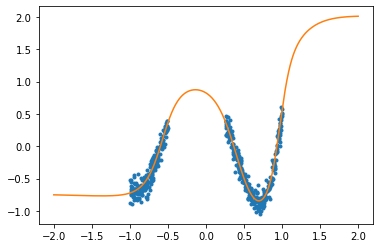

In [52]:
with torch.no_grad():
    Y_hat, sample_dict = sgld_model.sample_pred(
        X=X_range,
        deterministic=True,
        vi_batch_size=None,
        for_training=False,
    )

plt.plot(x,y, '.')
plt.plot(x_range, Y_hat.squeeze().cpu().numpy())

In [12]:
torch.save(sgld_model.state_dict(), "./test_sgld_model_map.pt")

In [13]:
import pickle
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

lvi_model_params = pickle.load(open("./test_sgld_model_params.pickle", "rb"))
lvi_model_params["group_by_layers"] = False
lvi_model_params["use_random_groups"] = True
lvi_model_params["use_permuted_groups"] = False
lvi_model_params["max_groups"] = 10
lvi_model_params["dropout_prob"] = 0.3
lvi_model_params["chain_length"] = 100000
lvi_model_params["output_distribution"] = "normal"
lvi_model_params["output_dist_const_params"] = dict(scale=std)

sgld_model = FF_BNN(**pickle.load(open("./test_sgld_model_params.pickle", "rb")))
sgld_model.load_state_dict(torch.load("./test_sgld_model_map.pt"))

lvi_model_params["init_values"] = {k:v.theta_actual.data for k,v in sgld_model.tensor_dict.items()}
del sgld_model

lvi_model = FF_BNN(**lvi_model_params)

lvi_model.initialize_optimizer(
    update_determ=False, 
    update_stoch=True, 
    lr=1e-3, 
    sgd=False, 
    sgld=False, 
    psgld=True,
)

In [14]:
dev = torch.device('cpu')
#dev = torch.device('cuda:0')

X, Y, X_range = X.to(dev), Y.to(dev), X_range.to(dev)
#sgld_model = sgld_model.to(dev)
lvi_model = lvi_model.to(dev)
#for n, t in sgld_model.tensor_dict.items():
for n, t in lvi_model.tensor_dict.items():
    if isinstance(t, StochasticTensor):
        t.prior_dist.loc = t.prior_dist.loc.to(dev)
        t.prior_dist.scale = t.prior_dist.scale.to(dev)

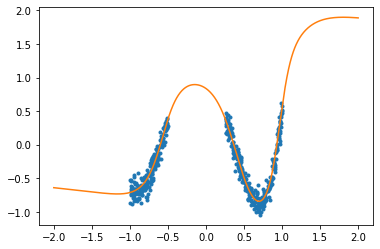

In [15]:
with torch.no_grad():
    Y_hat, sample_dict = lvi_model.sample_pred(
        X=X_range,
        deterministic=True,  #False,
        vi_batch_size=None,  #None,
        for_training=False,  #False,
    )

plt.plot(x,y, '.')
plt.plot(x_range, Y_hat.squeeze().cpu().numpy())

In [15]:
# print("Before initialization: {}".format(sgld_model.num_samples_per_group))
# sgld_model.init_chains()
# print("After initialization: {}".format(sgld_model.num_samples_per_group))
print("Before initialization: {}".format(lvi_model.num_samples_per_group))
lvi_model.init_chains()
print("After initialization: {}".format(lvi_model.num_samples_per_group))

Before initialization: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
After initialization: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [16]:
def plot_pred_intervals(model, num_pred_samples, title, path):
    with torch.no_grad():
        Y_hat, sample_dict = model.sample_pred(
            X=X_range,
            deterministic=False,  #False,
            vi_batch_size=num_pred_samples,  #None,
            for_training=False,  #False,
        )

    sorted_Y_hat, _ = torch.sort(Y_hat.squeeze(-1), dim=0)  # size: (pred_batch_dim, observation_idx)

    med_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.5), ...]
    #lower_ci_Y_hat = sorted_Y_hat[0, ...]
    #upper_ci_Y_hat = sorted_Y_hat[-1, ...]
    lower_ci_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.025), ...]
    upper_ci_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.975), ...]

    fig, ax = plt.subplots()
    ax.scatter(x,y,s=2, color="black")
    ax.plot(x_range, med_Y_hat.cpu().numpy())
    ax.fill_between(x_range, lower_ci_Y_hat.cpu().numpy(), upper_ci_Y_hat.cpu().numpy(), color='b', alpha=.2)
    ax.set_title(title)
    plt.show()
    if path is not None:
        fig.savefig(path, dpi=300, bbox_inches="tight")

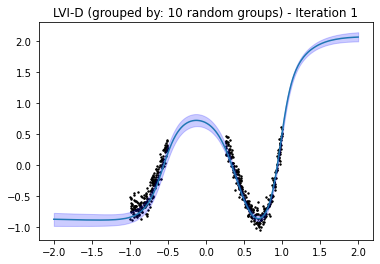

[2021-02-25 22:11:18.794746] Iter 1 / 150000, Loss: -1961.503173828125
[2021-02-25 22:11:18.803379] Iter 2 / 150000, Loss: 6285.3349609375
[2021-02-25 22:11:18.808550] Iter 3 / 150000, Loss: 5121.6650390625
[2021-02-25 22:11:18.813412] Iter 4 / 150000, Loss: 1471.223876953125
[2021-02-25 22:11:18.818107] Iter 5 / 150000, Loss: -1512.47509765625
[2021-02-25 22:11:18.822809] Iter 6 / 150000, Loss: -1862.998291015625
[2021-02-25 22:11:18.827529] Iter 7 / 150000, Loss: -1910.24169921875
[2021-02-25 22:11:18.832241] Iter 8 / 150000, Loss: -1930.80419921875
[2021-02-25 22:11:18.836950] Iter 9 / 150000, Loss: -1941.897705078125
[2021-02-25 22:11:18.841643] Iter 10 / 150000, Loss: -1958.26513671875
[2021-02-25 22:11:18.886901] Iter 20 / 150000, Loss: -1991.142333984375
[2021-02-25 22:11:18.931898] Iter 30 / 150000, Loss: -1997.671630859375
[2021-02-25 22:11:18.976866] Iter 40 / 150000, Loss: -1995.536865234375
[2021-02-25 22:11:19.022235] Iter 50 / 150000, Loss: -1995.796630859375
[2021-02-25 

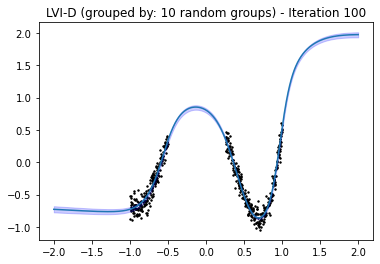

[2021-02-25 22:11:23.526409] Iter 100 / 150000, Loss: -1990.155517578125
[2021-02-25 22:11:24.281173] Iter 200 / 150000, Loss: 776.077880859375
[2021-02-25 22:11:25.036595] Iter 300 / 150000, Loss: 62.650634765625
[2021-02-25 22:11:25.660136] Iter 400 / 150000, Loss: 1103.88037109375
[2021-02-25 22:11:26.261069] Iter 500 / 150000, Loss: -227.846435546875
[2021-02-25 22:11:26.864835] Iter 600 / 150000, Loss: 697.15185546875
[2021-02-25 22:11:27.480919] Iter 700 / 150000, Loss: 158.4705810546875
[2021-02-25 22:11:28.082226] Iter 800 / 150000, Loss: 689.7989501953125
[2021-02-25 22:11:28.698540] Iter 900 / 150000, Loss: -107.6893310546875


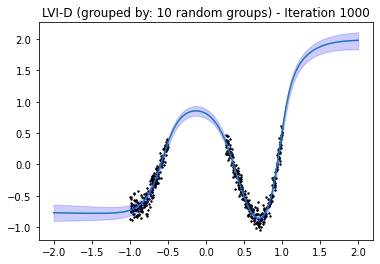

[2021-02-25 22:11:33.463210] Iter 1000 / 150000, Loss: 1104.4599609375
[2021-02-25 22:11:39.460339] Iter 2000 / 150000, Loss: 342.0777587890625
[2021-02-25 22:11:45.485631] Iter 3000 / 150000, Loss: 158.021728515625
[2021-02-25 22:11:51.483232] Iter 4000 / 150000, Loss: 1384.4947509765625
[2021-02-25 22:11:57.502681] Iter 5000 / 150000, Loss: 781.3212890625
[2021-02-25 22:12:03.488657] Iter 6000 / 150000, Loss: 1323.238037109375
[2021-02-25 22:12:09.434492] Iter 7000 / 150000, Loss: 1378.1290283203125
[2021-02-25 22:12:15.390823] Iter 8000 / 150000, Loss: 1081.51123046875
[2021-02-25 22:12:21.306487] Iter 9000 / 150000, Loss: 890.546875


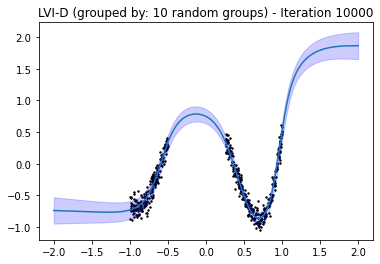

[2021-02-25 22:12:32.038362] Iter 10000 / 150000, Loss: 912.42138671875


KeyboardInterrupt: 

In [17]:
from datetime import datetime

num_epochs = 150000
for i in range(num_epochs):
       
    if i < 100:
        loss = lvi_model.training_step(
            batch=(X,Y),
            N=N,
            perform_sgld_update=True,  # First few iterations perform SGLD
            vi_batch_size=None,
        )
    else:
        loss = lvi_model.training_step(
            batch=(X,Y),
            N=N,
            vi_batch_size=4,  
            perform_sgld_update=False,  
        )

    if ((i+1) % 10000 == 0) or (i+1 == 1000) or (i+1 == 100) or (i == 0):
        plot_pred_intervals(
            model=lvi_model, 
            num_pred_samples=lvi_model.chain_length // 10, 
            title="LVI-D (grouped by: 10 random groups) - Iteration {}".format(i+1),
            path=None, # "./lvi_d_random10_model_iter_{}.png".format(i+1),  # if None, will not save image
        )
    
    if (i+1) % 10**math.floor(math.log10(i+1)) == 0:  # True when i+1 \in {1, 2, ..., 10, 20, ..., 100, 200, ..., 1000, 2000, ...}
        print("[{}] Iter {} / {}, Loss: {}".format(datetime.now(), i+1, num_epochs, loss))

In [49]:
lvi_model.use_dropout, lvi_model.num_samples_per_group

(True, tensor([1651, 1632, 1598, 1603, 1567, 1689, 1619, 1584, 1582, 1635]))

In [134]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp = GaussianProcessRegressor(kernel=RBF(), alpha=std ** 2, n_restarts_optimizer=10)
gp.fit(np.atleast_2d(x).T, y)

GaussianProcessRegressor(alpha=0.010000000000000002, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=10,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [135]:
y_pred, sigma = gp.predict(np.atleast_2d(x_range).T, return_std=True)

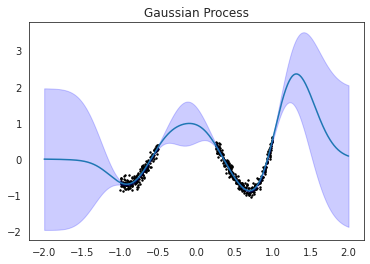

In [136]:
fig, ax = plt.subplots()
ax.scatter(x,y,s=2, color="black")
ax.plot(x_range, y_pred)
ax.fill_between(x_range, y_pred - 1.96*sigma, y_pred + 1.96*sigma, color='b', alpha=.2)
ax.set_title("Gaussian Process")
plt.show()

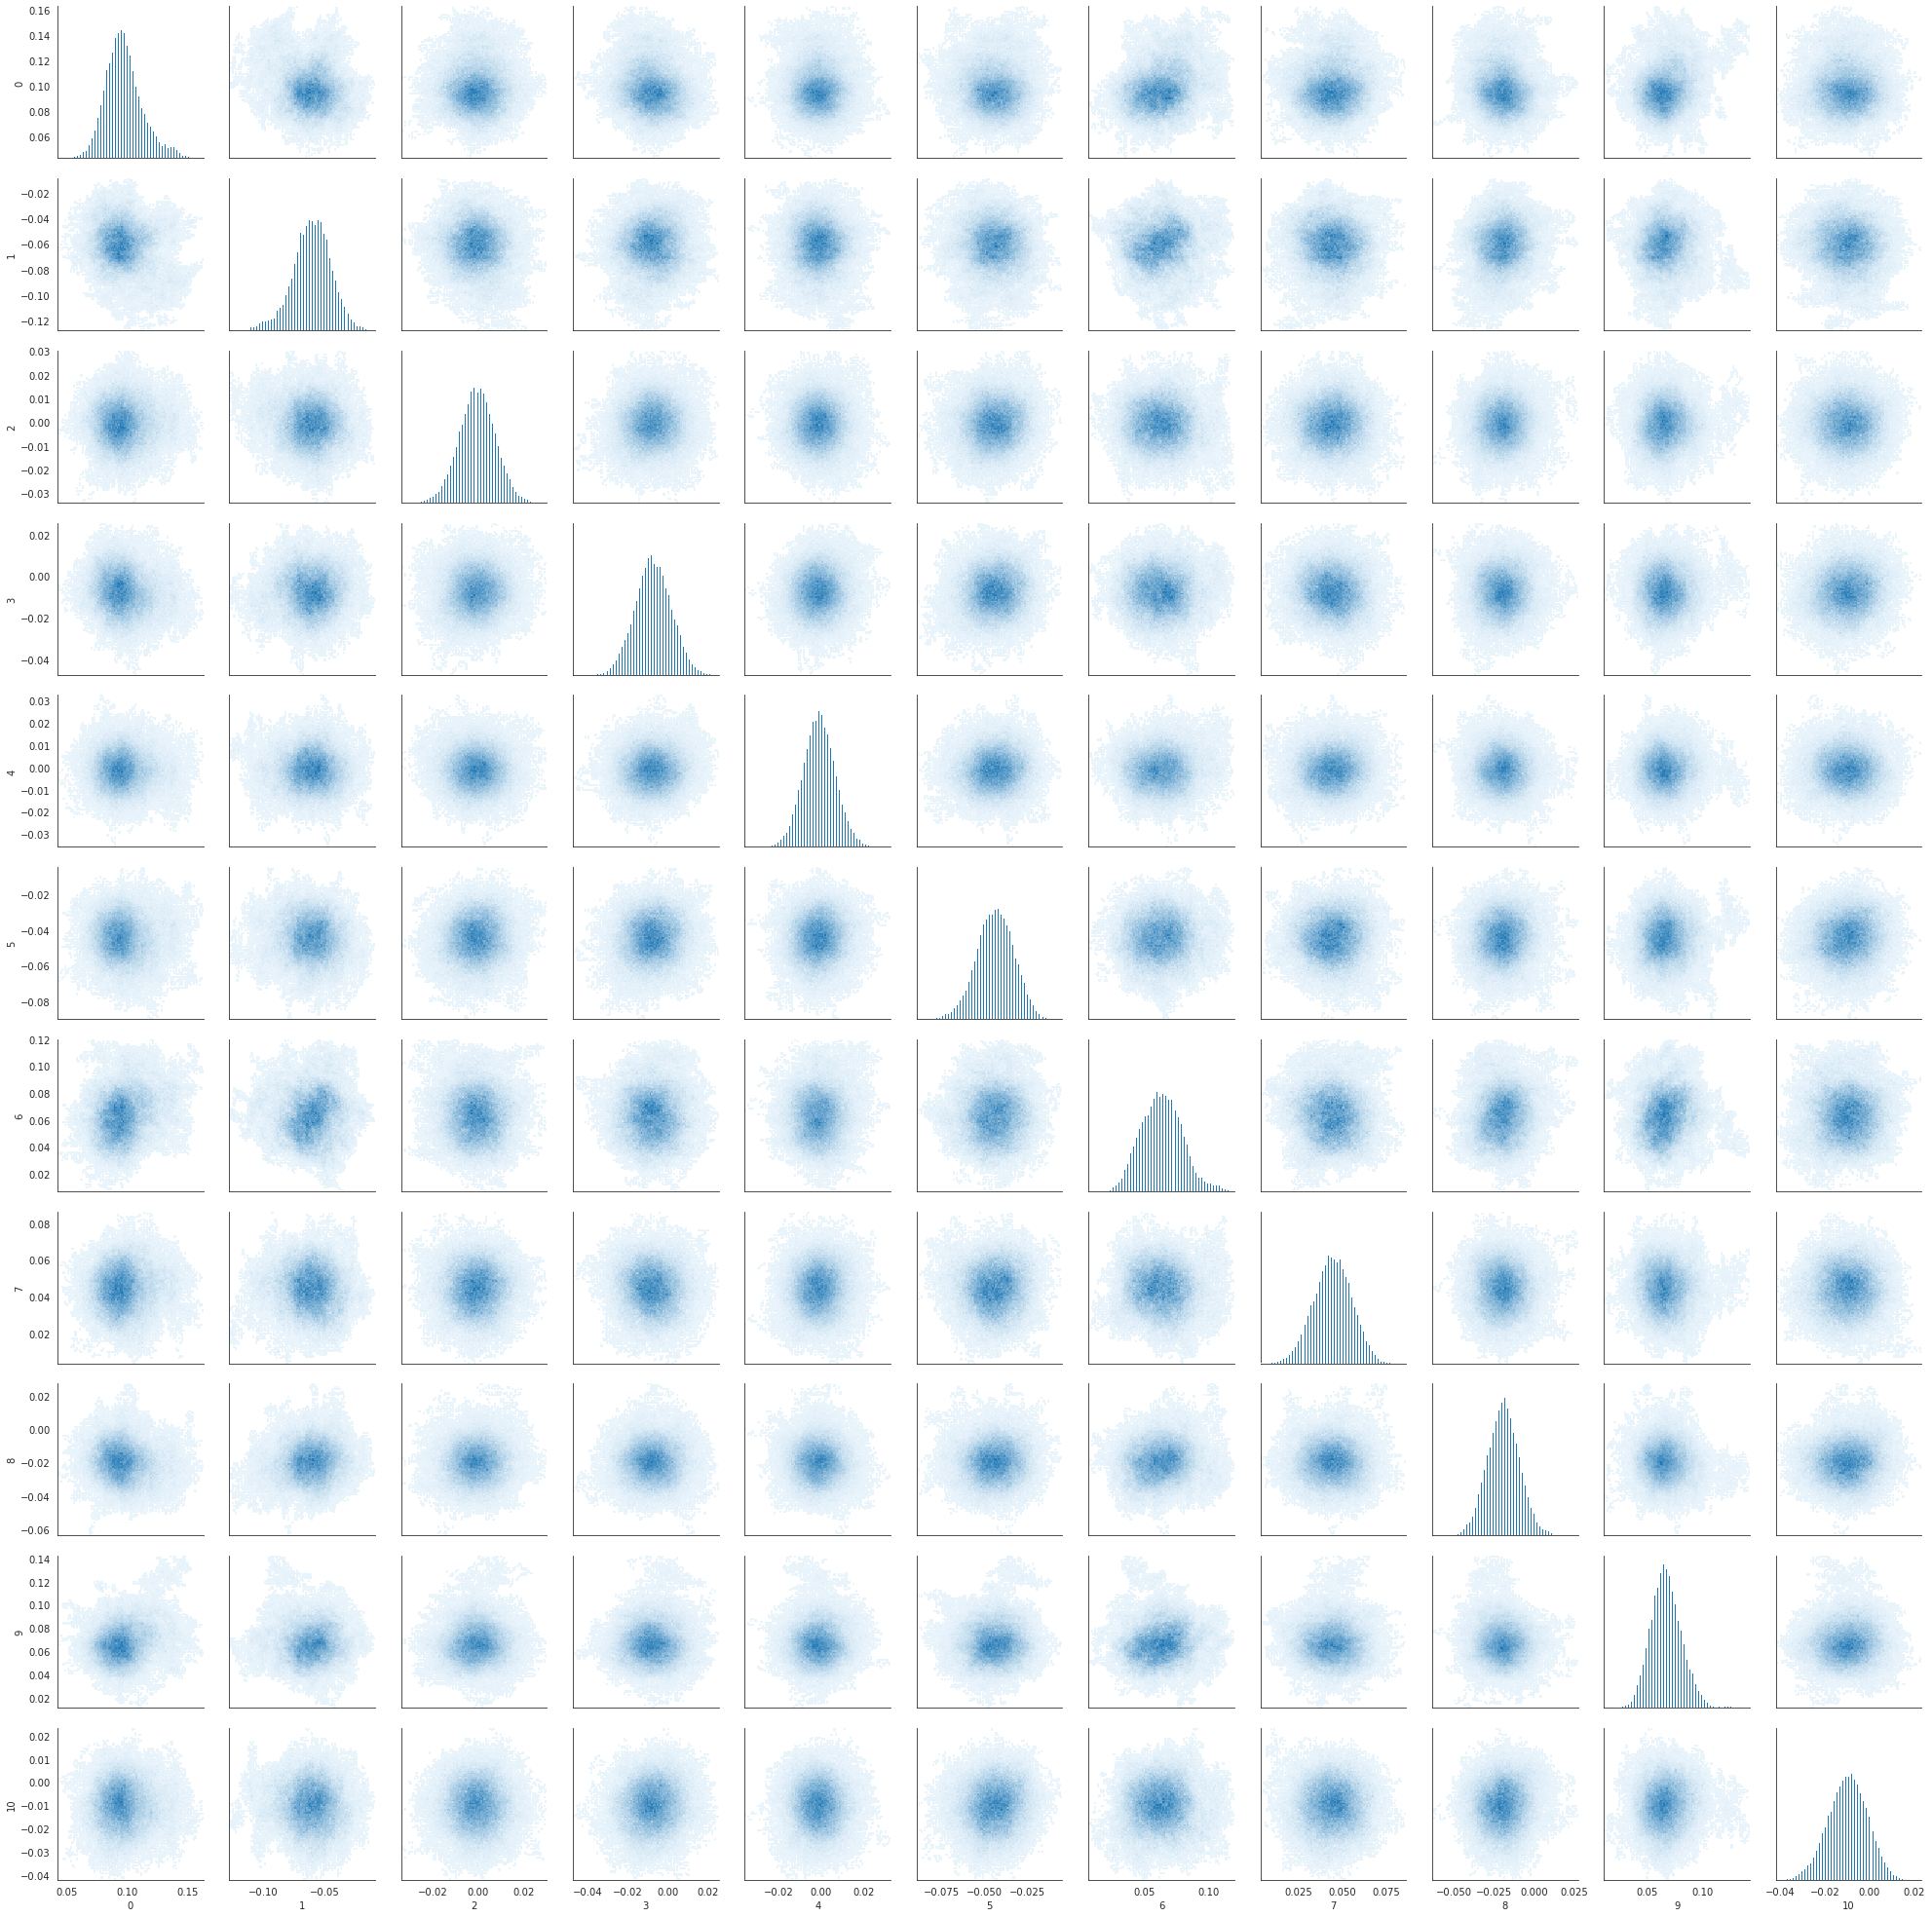

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style("white")

#to_plot = sgld_model.tensor_dict.W_2.theta_chains.view(sgld_model.chain_length, -1).cpu().detach().numpy()
#to_plot = lvi_model.tensor_dict.W_2.theta_chains.view(lvi_model.chain_length, -1).cpu().detach().numpy()
to_plot = lvi_model.tensor_dict.W_2.theta_chains[:, lvi_model.tensor_dict.W_2.parameter_map.squeeze() == 3, :].squeeze().cpu().detach().numpy()

g = sns.PairGrid(pd.DataFrame(to_plot))
g.map_diag(plt.hist, bins=100)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=100)

In [81]:
lvi_model.tensor_dict.W_2.theta_chains[:, lvi_model.tensor_dict.W_2.parameter_map.squeeze() == 0, :].squeeze()

tensor([[ 0.0488,  0.1205, -0.0133,  0.0117,  0.0835,  0.0211],
        [ 0.0475,  0.1181, -0.0104,  0.0098,  0.0832,  0.0231],
        [ 0.0471,  0.1179, -0.0106,  0.0101,  0.0824,  0.0251],
        ...,
        [ 0.0452,  0.1180, -0.0187,  0.0081,  0.0860,  0.0186],
        [ 0.0448,  0.1195, -0.0162,  0.0096,  0.0853,  0.0195],
        [ 0.0461,  0.1194, -0.0159,  0.0093,  0.0869,  0.0207]],
       grad_fn=<SqueezeBackward0>)

In [122]:
sgld_model.tensor_dict.W_2.theta_chains

tensor([[[-0.0048],
         [-0.0361],
         [-0.0188],
         ...,
         [ 0.0218],
         [-0.0042],
         [-0.0580]],

        [[ 0.0778],
         [-0.1493],
         [-0.0068],
         ...,
         [ 0.0574],
         [-0.0127],
         [-0.0882]],

        [[ 0.0767],
         [-0.1490],
         [-0.0070],
         ...,
         [ 0.0559],
         [-0.0153],
         [-0.0886]],

        ...,

        [[-0.0048],
         [-0.0346],
         [-0.0191],
         ...,
         [ 0.0188],
         [-0.0033],
         [-0.0607]],

        [[-0.0067],
         [-0.0353],
         [-0.0196],
         ...,
         [ 0.0203],
         [-0.0022],
         [-0.0612]],

        [[-0.0048],
         [-0.0340],
         [-0.0177],
         ...,
         [ 0.0193],
         [-0.0028],
         [-0.0587]]], device='cuda:0', grad_fn=<ScatterBackward0>)

In [88]:
?nn.GRU

Init signature: nn.GRU(*args, **kwargs)
Docstring:     
Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.


For each element in the input sequence, each layer computes the following
function:

.. math::
    \begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}

where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
:math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
:math:`\sigma` is the sigmoid function, and :math:`*` is the Hadamard product.

In a multilayer GRU, the input :math:`x^{(l)}_t` of the :math:`l` -th layer
(:math:`l >= 2`